# Implementing Logistic Regression

## Abstract

Link to [logistic source code](https://github.com/EpicET/EpicET.github.io/blob/main/posts/blog5/logistic.py).

This notebook implements a logistic regression model with a gradient descent optimizer. The model is trained on a synthetic dataset, and in where it is optimized at each iteration and also updates loss. There are four experiments conducted. The first experiment tested the model on with vanilla gradient descent plotting the loss per iteration and a decision boundary. The second experiment compared the loss per iterations between the model when using the vanilla descent and when using momentum descent. The third experiment was to overfit the model to the training data and compare it to the accuracy of the model on the test data. The fourth experiment was to test the model on a heart disease prediction dateset. The dataset was split into training, validation, and test data.  The model was trained on the training data and the loss computed for both training and validation. The model was then evaluated on the test data, and the accuracy was reported.

In [3]:
%load_ext autoreload
%autoreload 2

from logistic import LogisticRegression, GradientDescentOptimizer
import torch


In [4]:
import numpy as np


def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)


This code was adapted from previous notes.

In [5]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

def plot_classification_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -1, vmax = 2, alpha = 0.8, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, X, y, x_min, x_max, **kwargs):
    fig, ax = plt.subplots(1, 1)
    plot_classification_data(X, y, ax)
    x = torch.linspace(x_min, x_max, 101)
    y = -(w[0]*x + w[2])/w[1]
    l = ax.plot(x, y, **kwargs)

## Experiments

### Experiment 1: Vanilla Logistic Regression


In [6]:
print(X.shape)

torch.Size([300, 3])


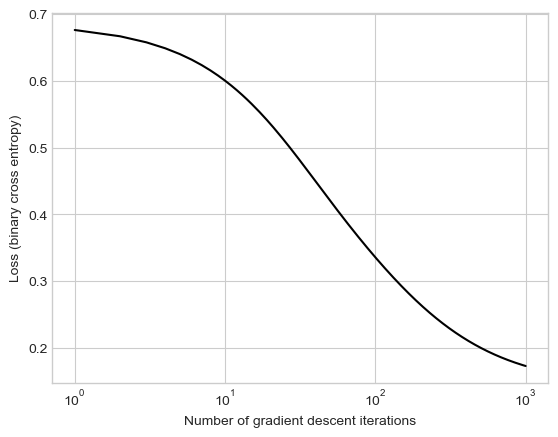

In [7]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec = []

for _ in range(1000):
    
    loss = LR.loss(X, y) 
    loss_vec.append(loss)
    
    # add other stuff to e.g. keep track of the loss over time. 
    opt.step(X, y, alpha = 0.1, beta = 0)

  
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

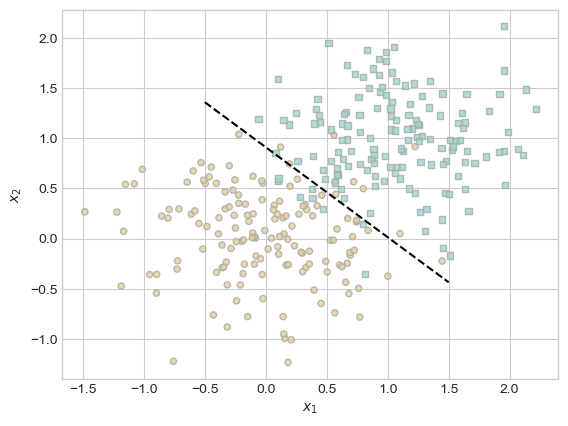

In [8]:
draw_line(opt.model.w, X, y, x_min = -0.5, x_max = 1.5, color = "black", linestyle = "dashed")

The code above implements a vanilla gradient descent with logistic regression. It is run through a training loop, while keeping track of the loss and storing it in an array called loss_vec. Using loss_vec, I plot a graph showing the loss over gradient iterations. The second graph shows the decision boundary of the data. 
- Loss: This appears to start at ~0.67 and decreases to ~0.33 over the course of 100 iterations. 
- Decision Boundary: The decision boundary appears to correctly classify the data.

### Experiment 2: Benefits of Momentum

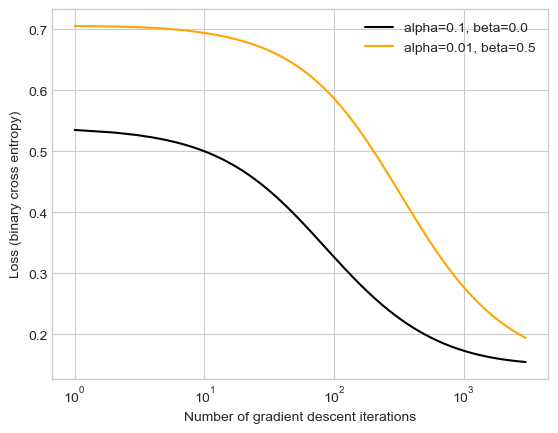

In [9]:
import matplotlib.pyplot as plt
import torch

# Vanilla gradient descent
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec1 = []
iterations = 3000

for _ in range(iterations):
    loss = LR.loss(X, y)
    loss_vec1.append(loss)
    opt.step(X, y, alpha=0.1, beta=0.0)  # baseline

# Momentum version
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

loss_vec2 = []
for _ in range(iterations):
    loss = LR.loss(X, y)
    loss_vec2.append(loss)
    opt.step(X, y, alpha=0.01, beta=0.5)  # momentum version


plt.plot(torch.arange(1, len(loss_vec1) + 1), loss_vec1, color="black", label="alpha=0.1, beta=0.0")
plt.plot(torch.arange(1, len(loss_vec2) + 1), loss_vec2, color="orange", label="alpha=0.01, beta=0.5")

plt.semilogx()
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Loss (binary cross entropy)")
plt.legend()
plt.show()


The code above plots the loss over iterations for both vanilla gradient descent and momentum gradient descent (alpha = 0.01, beta = 0.5) over the same amount of iterations. The momentum gradient descent currently appears to converge slower than the vanilla gradient descent. This may be due to not identifying the correct parameters for the momentum gradient descent.

### Experiment 3: Overfitting

In [10]:
X_train, y_train = classification_data(n_points= 50, noise = 0.5, p_dims = 100)
X_test, y_test = classification_data(n_points= 50, noise = 0.5, p_dims = 100)

In [11]:
LR = LogisticRegression() 
opt = GradientDescentOptimizer(LR)

for _ in range(50): 
    opt.step(X_train, y_train, alpha = 0.1, beta = 0.9)
    

In [12]:
# Calculate training accuracy
train_predictions = LR.predict(X_train)
train_accuracy = (train_predictions == y_train).float().mean().item()
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Calculate testing accuracy
test_predictions = LR.predict(X_test)
test_accuracy = (test_predictions == y_test).float().mean().item()
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 100.00%
Testing Accuracy: 88.00%


Here both the training accuracy and the testing accuracy for their relative sets. The training accuracy was able to achieve 100% accuracy, while the testing accuracy was only able to achieve 92% accuracy. This indicates that the model is overfitting to the training data, though it still has a pretty good accuracy on the test data. 

### Experiment 4: Performance ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍on ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍empirical ‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍‍data

In [13]:
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split

# Download dataset from Kaggle
path = kagglehub.dataset_download("shantanugarg274/heart-prediction-dataset-quantum")
print("Path to dataset files:", path)

data_path = path + "/Heart Prediction Quantum Dataset.csv"
df = pd.read_csv(data_path)
print(df.head())

Path to dataset files: /Users/emmanueltowner/.cache/kagglehub/datasets/shantanugarg274/heart-prediction-dataset-quantum/versions/1
   Age  Gender  BloodPressure  Cholesterol  HeartRate  QuantumPatternFeature  \
0   68       1            105          191        107               8.362241   
1   58       0             97          249         89               9.249002   
2   44       0             93          190         82               7.942542   
3   72       1             93          183        101               6.495155   
4   37       0            145          166        103               7.653900   

   HeartDisease  
0             1  
1             0  
2             1  
3             1  
4             1  


In [14]:

X_data = df.drop("HeartDisease", axis=1).values
y_data = df["HeartDisease"].values

X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert the numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
y_val   = torch.tensor(y_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.float32)


In [15]:
print("X.shape:", X.shape)
print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)

print(y.shape)
print(y_train.shape)
print(y_val.shape)

X.shape: torch.Size([300, 3])
X_train.shape: torch.Size([300, 6])
X_val.shape: torch.Size([100, 6])
torch.Size([300])
torch.Size([300])
torch.Size([100])


In [16]:
print("X:", X[0:5])
print("X_train:", X_train[0:5])

X: tensor([[-0.1976, -0.0275,  1.0000],
        [-0.3243, -0.2340,  1.0000],
        [-1.0787,  0.5452,  1.0000],
        [-0.7275, -0.3037,  1.0000],
        [-0.0294, -0.3578,  1.0000]])
X_train: tensor([[ 30.0000,   1.0000, 109.0000, 246.0000,  62.0000,   7.6140],
        [ 69.0000,   1.0000, 157.0000, 161.0000, 118.0000,   7.8521],
        [ 35.0000,   0.0000, 118.0000, 208.0000,  61.0000,   8.1145],
        [ 42.0000,   0.0000, 102.0000, 201.0000,  71.0000,   7.1339],
        [ 58.0000,   0.0000, 133.0000, 211.0000,  99.0000,   8.9405]])


In [17]:
print("y:", y[0:5])
print("y_train:", y_train[0:5])

y: tensor([0., 0., 0., 0., 0.])
y_train: tensor([1., 1., 1., 1., 0.])


train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tensor(nan)
train_loss: tens

Text(0.5, 1.0, 'Training Loss')

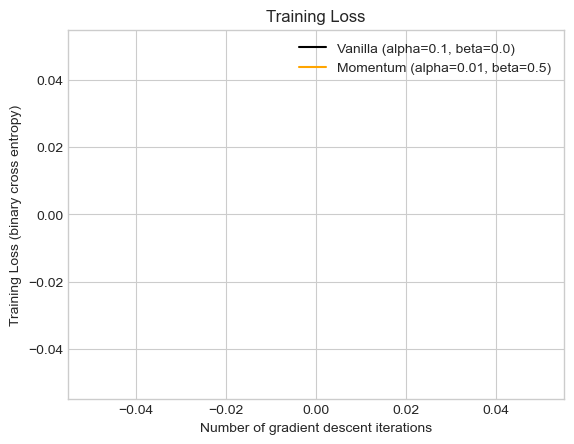

In [ ]:
import matplotlib.pyplot as plt
import torch

# Vanilla gradient descent
LRV = LogisticRegression() 
optv = GradientDescentOptimizer(LRV)

v_loss_train = []
v_loss_val = []

iterations = 100

for _ in range(iterations):
    train_loss = LRV.loss(X_train, y_train)
    val_loss = LRV.loss(X_val, y_val)
    v_loss_train.append(train_loss) # All loss retuns tensor(nan)
    v_loss_val.append(val_loss)
    optv.step(X_train, y_train, alpha=0.1, beta=0.0)  # baseline

# Momentum version
LRM = LogisticRegression() 
optm = GradientDescentOptimizer(LRM)

m_loss_train = []
m_loss_val = []
for _ in range(iterations):
    train_loss = LRM.loss(X_train, y_train)
    val_loss = LRM.loss(X_val, y_val)
    m_loss_train.append(train_loss)
    m_loss_val.append(val_loss)
    optm.step(X_train, y_train, alpha=0.01, beta=0.9)  # momentum version

plt.plot(torch.arange(1, iterations + 1), v_loss_train, color="black", label="Vanilla (alpha=0.1, beta=0.0)")
plt.plot(torch.arange(1, iterations + 1), m_loss_train, color="orange", label="Momentum (alpha=0.01, beta=0.5)")
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Training Loss (binary cross entropy)")
plt.legend()
plt.title("Training Loss")


Text(0.5, 1.0, 'Validation Loss')

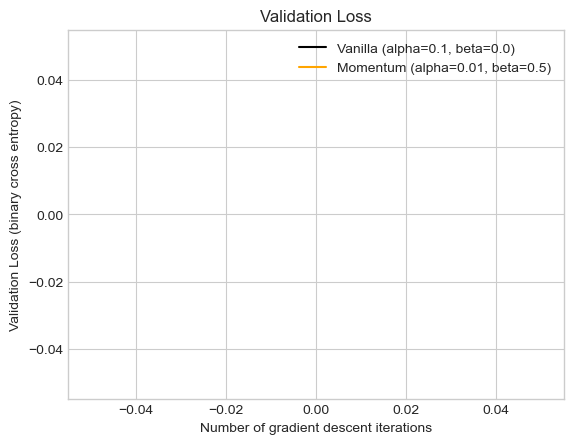

In [ ]:
plt.plot(torch.arange(1, iterations + 1), v_loss_val, color="black", label="Vanilla (alpha=0.1, beta=0.0)")
plt.plot(torch.arange(1, iterations + 1), m_loss_val, color="orange", label="Momentum (alpha=0.01, beta=0.5)")
plt.xlabel("Number of gradient descent iterations")
plt.ylabel("Validation Loss (binary cross entropy)")
plt.legend()
plt.title("Validation Loss")

## Discussion